In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from scipy.interpolate import griddata
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("./capture_data/clean_data.csv")
df.columns = df.columns.str.strip()

In [38]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["time_str"] = df["timestamp"].dt.strftime("%H:%M:%S")

# Metrics to visualize
metrics = ["temperature_f", "moisture_pct", "ec_us_cm", "ph", "n_mg_kg", "p_mg_kg", "k_mg_kg"]

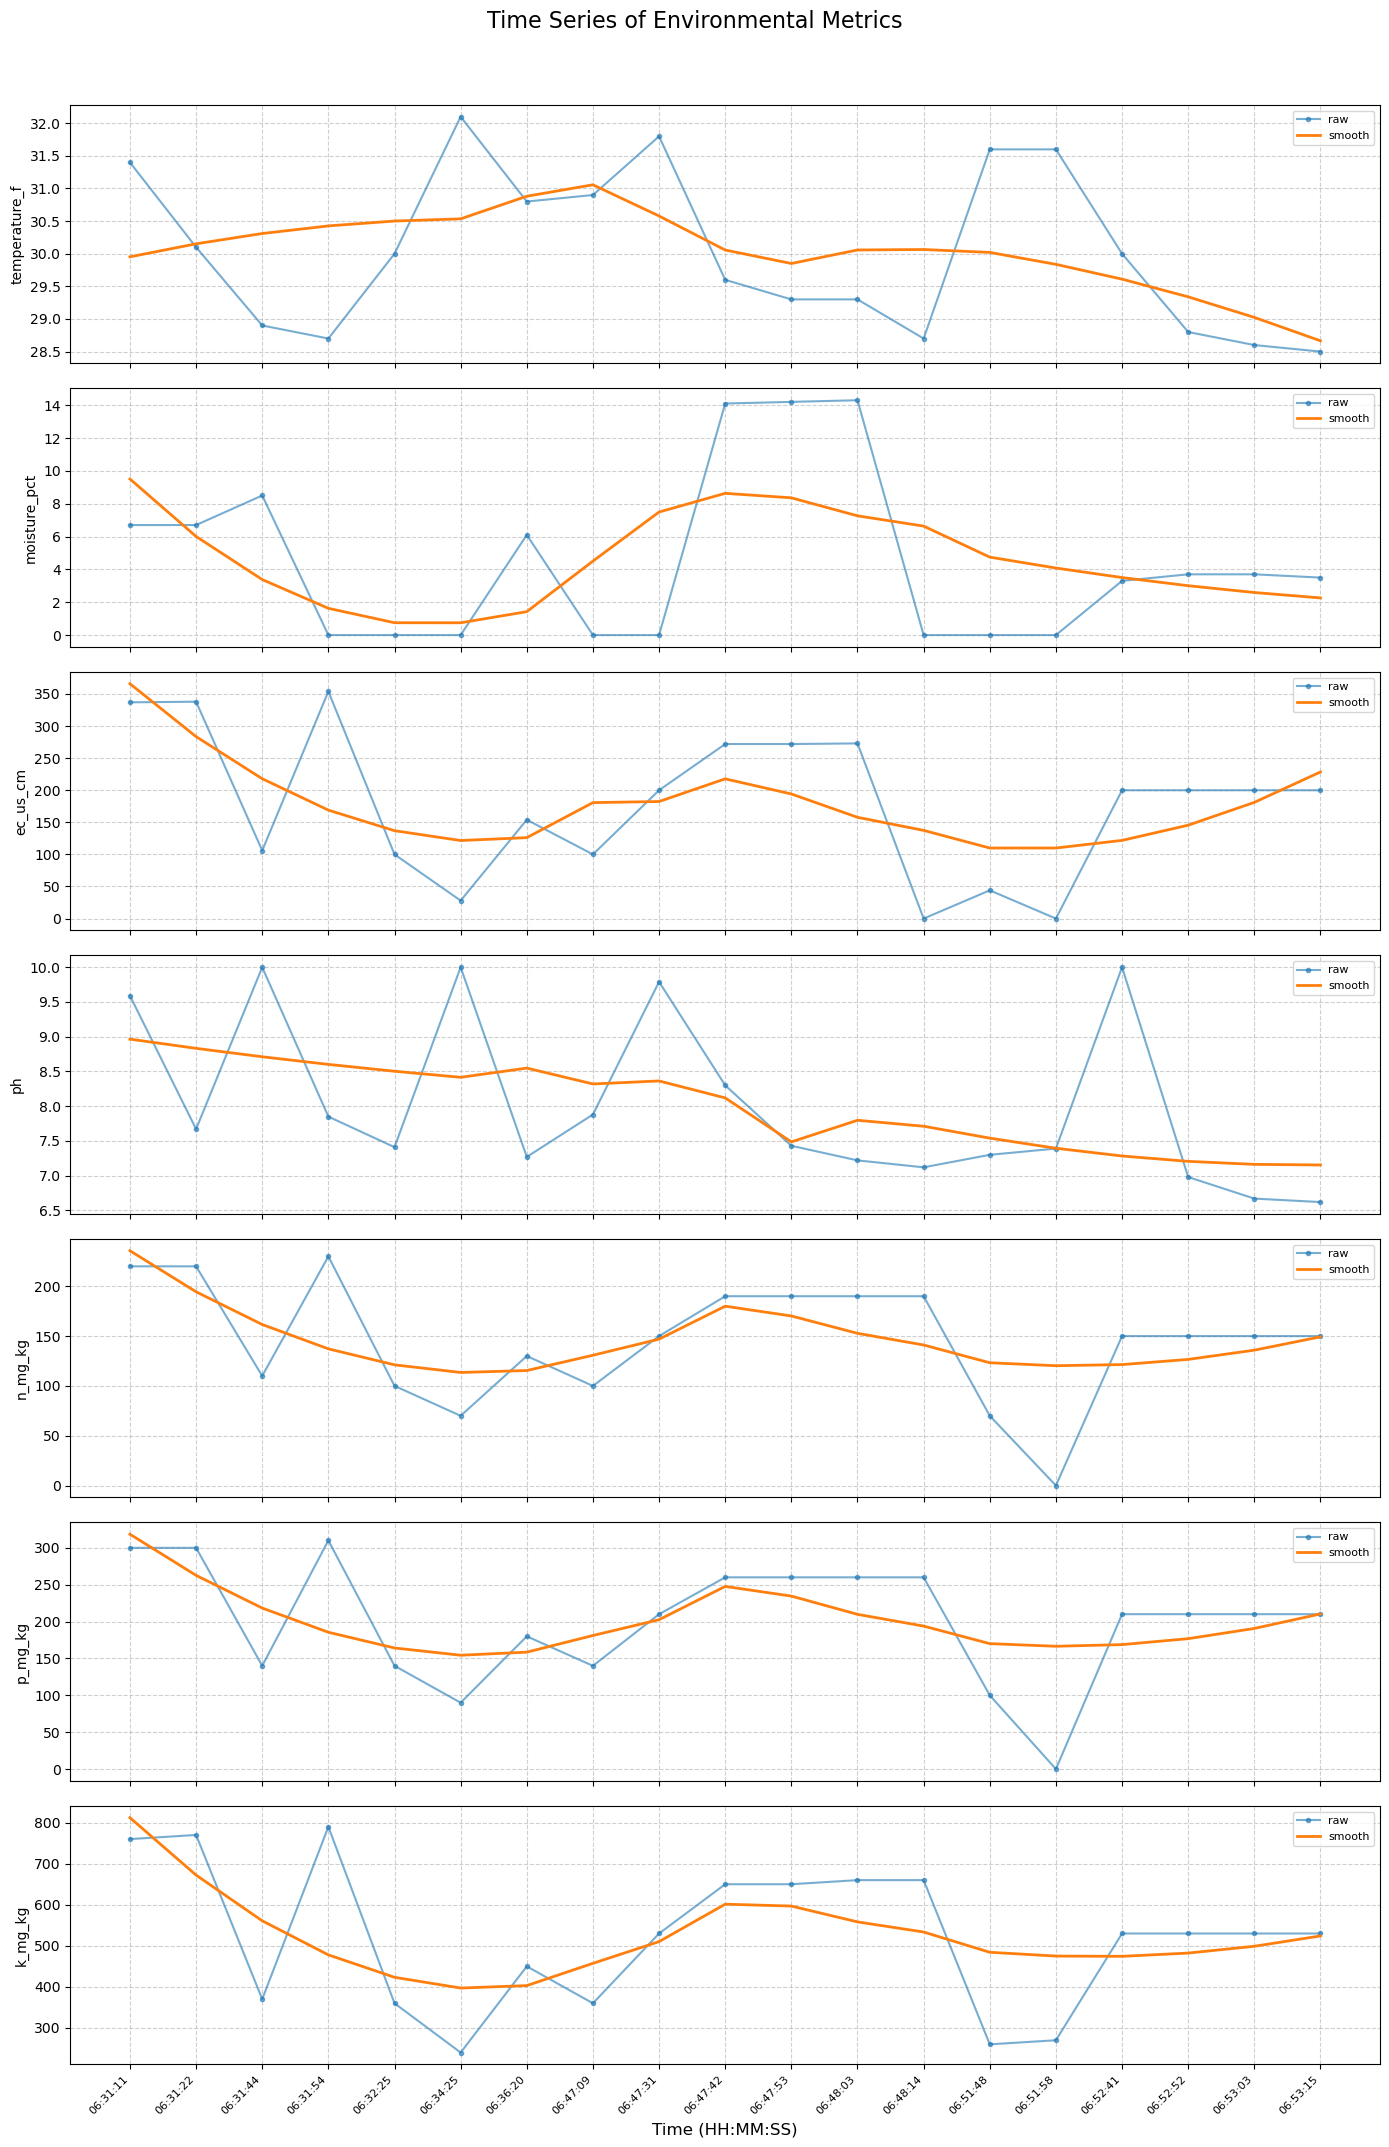

In [39]:
df["time_str"] = pd.to_datetime(df["timestamp"]).dt.strftime("%H:%M:%S")

fig, axes = plt.subplots(len(metrics), 1, figsize=(14, 3*len(metrics)), sharex=True)

for i, col in enumerate(metrics):
    ax = axes[i]
    
    # X and Y values
    x = np.arange(len(df))  # numeric index for plotting
    y = df[col].values.astype(float)
    
    # Plot raw points
    ax.plot(x, y, marker="o", markersize=3, linestyle="-", alpha=0.6, label="raw")
    
    # Smoothed curve with Savitzky-Golay filter (fallback to rolling mean if not enough points)
    window = min(11, len(y) if len(y) % 2 == 1 else len(y)-1)  # odd window ≤ data length
    if window >= 5:  
        y_smooth = savgol_filter(y, window, polyorder=2)
    else:
        y_smooth = pd.Series(y).rolling(window=3, min_periods=1).mean().to_numpy()
    
    ax.plot(x, y_smooth, linewidth=2, label="smooth")
    
    # Axis formatting
    ax.set_ylabel(col, fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(fontsize=8)
    
    # Add time labels for each subplot
    step = max(1, len(x)//10)  # about 10 ticks
    ax.set_xticks(x[::step])
    ax.set_xticklabels(df["time_str"].iloc[::step], rotation=45, ha="right", fontsize=8)

# Shared X label
axes[-1].set_xlabel("Time (HH:MM:SS)", fontsize=12)

plt.suptitle("Time Series of Environmental Metrics", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("./plots/time_series_environmental_metrics.png", dpi=300, bbox_inches="tight")
plt.show()


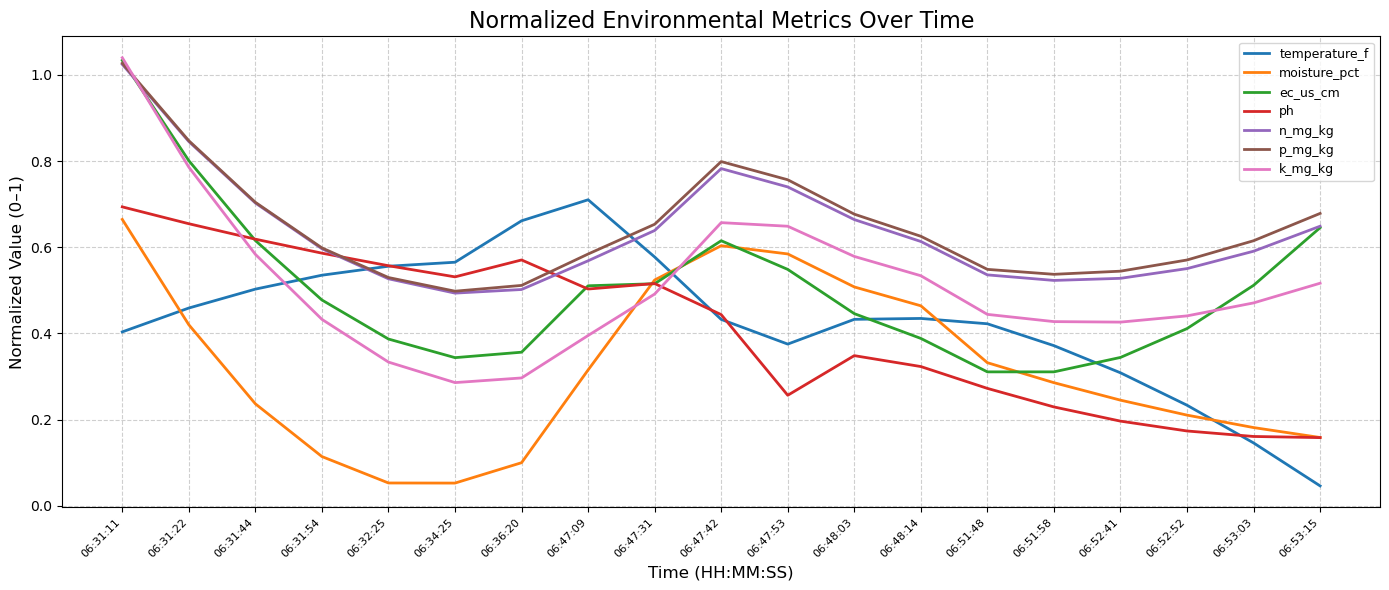

In [40]:
# Convert timestamp to readable format
df["time_str"] = pd.to_datetime(df["timestamp"]).dt.strftime("%H:%M:%S")


# Normalize metrics (0–1 scaling)
scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[metrics] = scaler.fit_transform(df[metrics].astype(float))

# Plot smoothed normalized values on same graph
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(df))

for col in metrics:
    y = df_norm[col].values
    
    # Smooth with Savitzky-Golay or rolling mean
    window = min(11, len(y) if len(y) % 2 == 1 else len(y)-1)
    if window >= 5:
        y_smooth = savgol_filter(y, window, polyorder=2)
    else:
        y_smooth = pd.Series(y).rolling(window=3, min_periods=1).mean().to_numpy()
    
    ax.plot(x, y_smooth, linewidth=2, label=col)

# X-axis labels (time)
step = max(1, len(x)//10)
ax.set_xticks(x[::step])
ax.set_xticklabels(df["time_str"].iloc[::step], rotation=45, ha="right", fontsize=8)

ax.set_xlabel("Time (HH:MM:SS)", fontsize=12)
ax.set_ylabel("Normalized Value (0–1)", fontsize=12)
ax.set_title("Normalized Environmental Metrics Over Time", fontsize=16)
ax.legend(fontsize=9)
ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig("./plots/normalized_metrics_over_time.png", dpi=300, bbox_inches="tight")
plt.show()

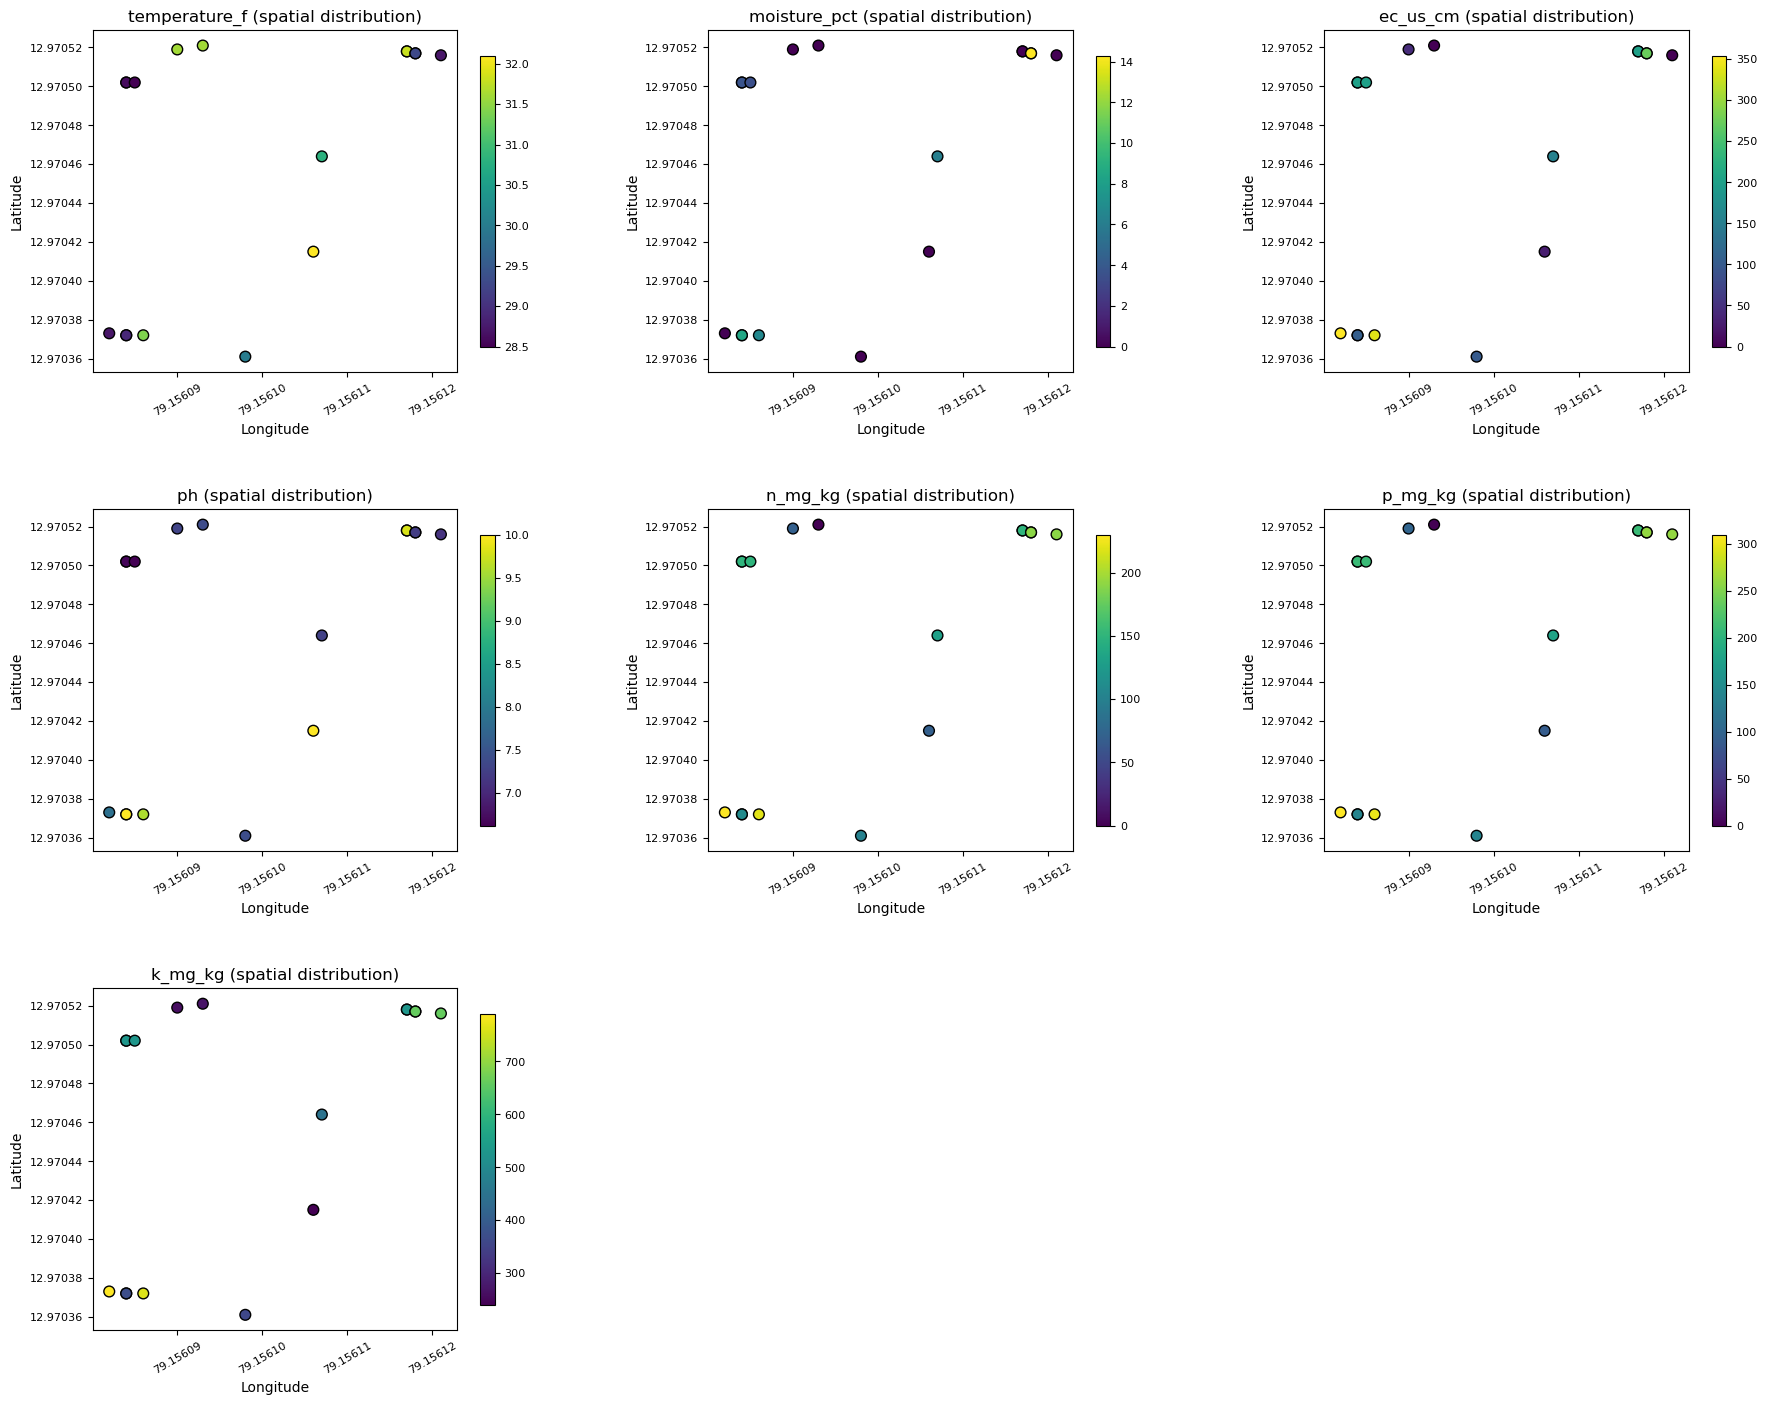

In [41]:
# ---------- FIXED SPATIAL SCATTER PLOTS (no scientific notation overlap) ----------
n_metrics = len(metrics)
n_cols = 3  # up to 3 plots per row
n_rows = math.ceil(n_metrics / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(metrics):
    sc = axes[i].scatter(
        df["longitude"].to_numpy().ravel(),
        df["latitude"].to_numpy().ravel(),
        c=df[col].to_numpy().ravel(),
        cmap="viridis", s=60, edgecolor="k"
    )
    axes[i].set_title(f"{col} (spatial distribution)", fontsize=12)
    axes[i].set_xlabel("Longitude")
    axes[i].set_ylabel("Latitude")

    # Force plain formatting (no scientific notation)
    axes[i].xaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
    axes[i].yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))

    # Rotate ticks for clarity
    for label in axes[i].get_xticklabels():
        label.set_rotation(30)
        label.set_fontsize(8)
    for label in axes[i].get_yticklabels():
        label.set_fontsize(8)

    cbar = plt.colorbar(sc, ax=axes[i], shrink=0.85)
    cbar.ax.tick_params(labelsize=8)

# Hide unused axes
for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.35)
plt.savefig("./plots/spatial_scatter_plots.png", dpi=300, bbox_inches="tight")
plt.show()

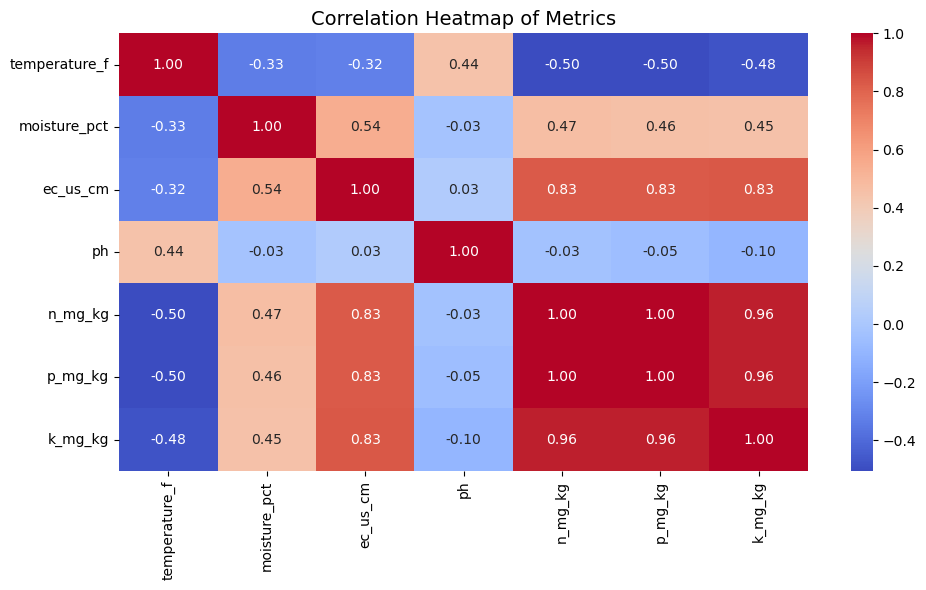

In [42]:
plt.figure(figsize=(10, 6))
corr = df[metrics].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Metrics", fontsize=14)
plt.tight_layout()
plt.savefig("./plots/correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

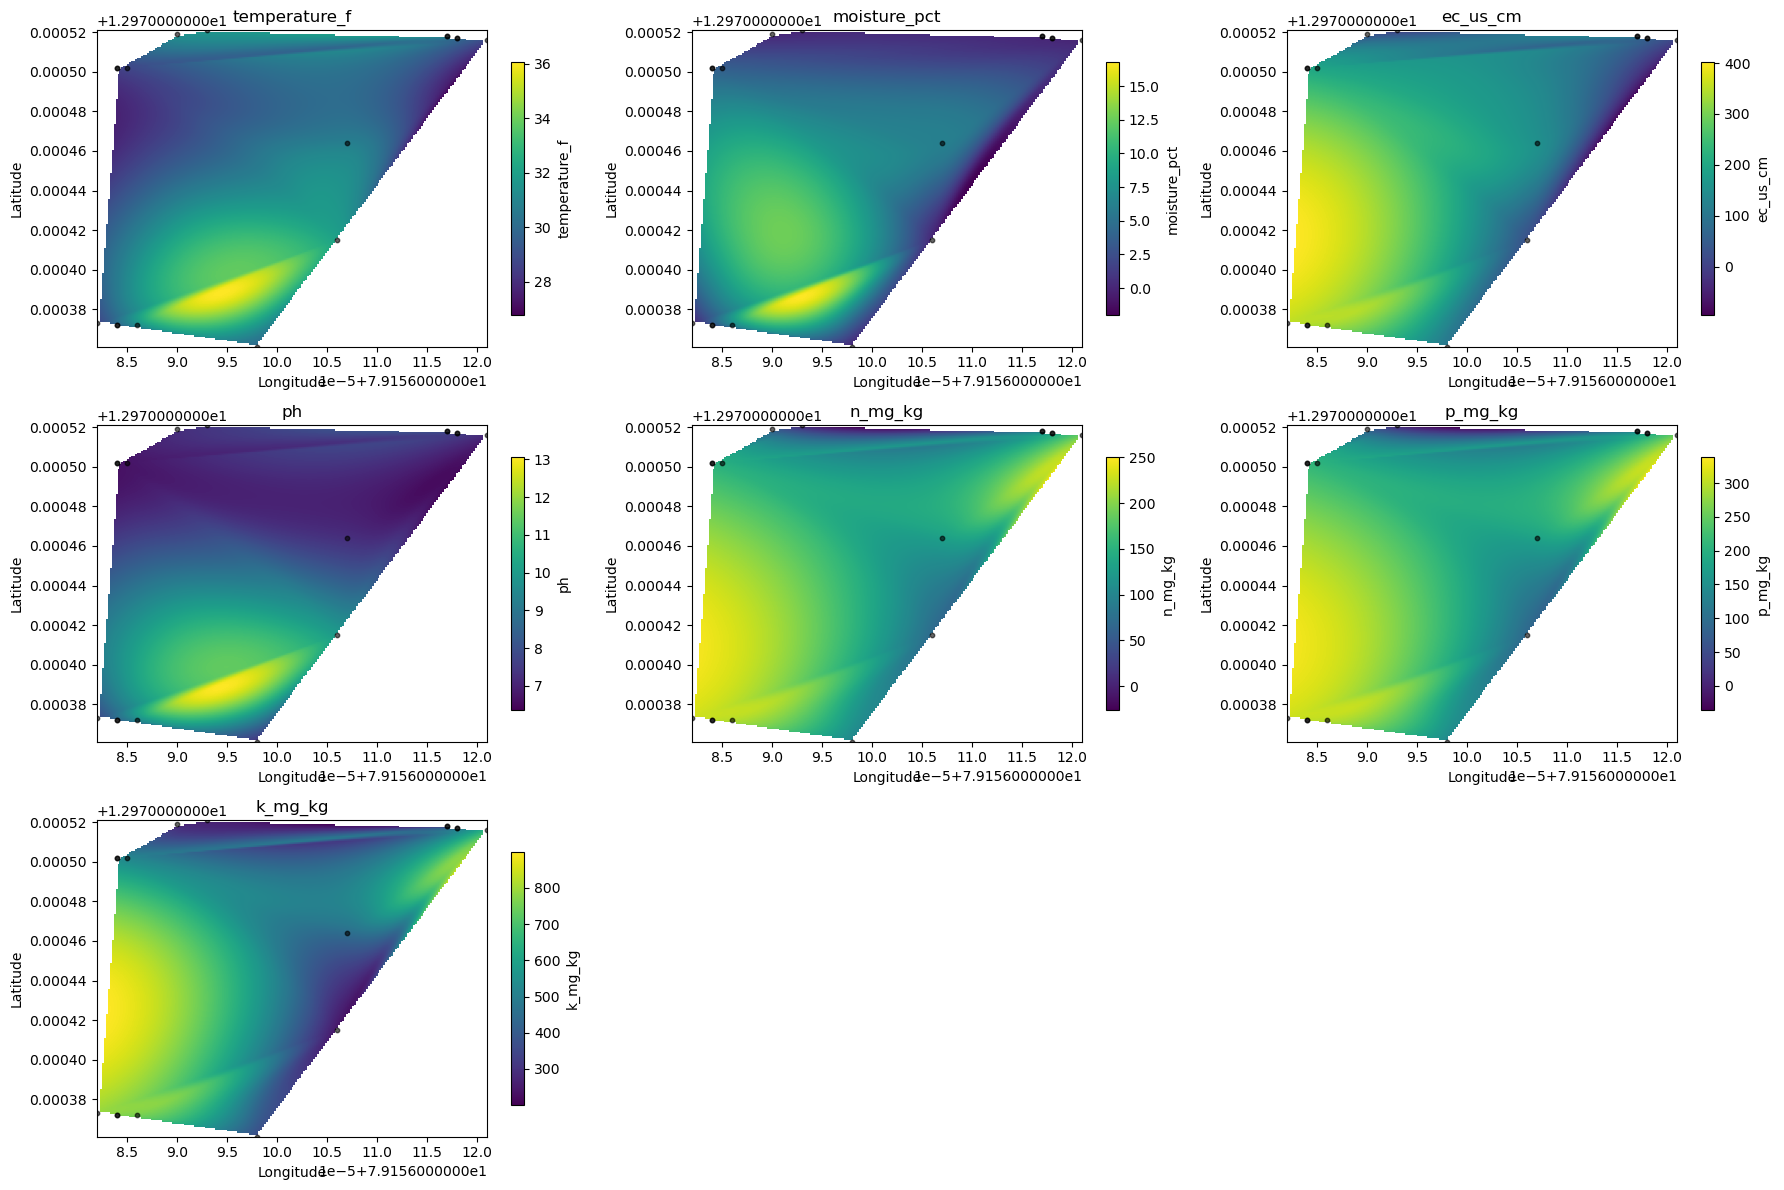

In [43]:
df_clean = df.dropna(subset=["latitude", "longitude"] + metrics)

lat = df_clean["latitude"].values
lon = df_clean["longitude"].values

# Define voxel grid resolution (increase 200j for smoother maps)
grid_x, grid_y = np.mgrid[
    lon.min():lon.max():200j,
    lat.min():lat.max():200j
]

# Subplots
n = len(metrics)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    values = df_clean[metric].values

    try:
        grid_z = griddata((lon, lat), values, (grid_x, grid_y), method="cubic")
    except Exception:
        grid_z = griddata((lon, lat), values, (grid_x, grid_y), method="linear")

    # Plot heatmap
    im = axes[i].imshow(
        grid_z.T, extent=(lon.min(), lon.max(), lat.min(), lat.max()),
        origin="lower", cmap="viridis", aspect="auto"
    )
    fig.colorbar(im, ax=axes[i], label=metric, shrink=0.8)
    axes[i].scatter(lon, lat, c="k", s=10, alpha=0.6)
    axes[i].set_title(metric)
    axes[i].set_xlabel("Longitude")
    axes[i].set_ylabel("Latitude")

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig("./plots/spatial_heatmaps.png", dpi=300, bbox_inches="tight")
plt.show()